# **Task 3: Customer Segmentation using Clustering**

This notebook demonstrates customer segmentation through clustering techniques. The goal is to segment customers based on both their **profile information** and **transaction data**. We will utilize the **KMeans** clustering algorithm and evaluate its performance using the **Davies-Bouldin Index**.

---



In [1]:
# **Importing necessary libraries**

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


### **Step 1: Load the Data**

Here, we load the three datasets: **Customers**, **Transactions**, and **Products**. The data will be preprocessed to create a merged customer profile for clustering.

---


In [2]:
# **Loading the datasets**

# Load the customer data, transaction data, and product data
customers = pd.read_csv(r"C:\Users\mistr\Desktop\zeotap\data\Customers.csv")
transactions = pd.read_csv(r"C:\Users\mistr\Desktop\zeotap\data\Transactions.csv")
products = pd.read_csv(r"C:\Users\mistr\Desktop\zeotap\data\Products.csv")


### **Step 2: Merge the Datasets and Calculate Category Spend**

Next, we merge the transaction and product data to get the category for each product in a transaction. We then calculate how much each customer spent on each product category.

---


In [3]:
# **Merging datasets and calculating spend per category**

# Merge transaction data with product category to get category information for each transaction
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')

# Calculate how much each customer spent on each category
category_spend = transactions.groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack(fill_value=0)

# Merge category spend data into the customer profile
customer_profile = customers.merge(category_spend, on='CustomerID', how='left')


### **Step 3: Handle Missing Values**

In this step, we fill any missing category spend values with **0**. This ensures that all customers have values for every product category.

---


In [4]:
# **Handling missing values**

# Fill missing values with 0 for any missing category spend data
customer_profile.fillna(0, inplace=True)


### **Step 4: Standardize the Data**

We scale the numerical data (category spends) using **StandardScaler** so that all features have zero mean and unit variance.

---


In [5]:
# **Standardizing the data**

# Normalize the numerical columns (category spends) by scaling them to have zero mean and unit variance
numerical_cols = list(category_spend.columns)  # Select category columns for scaling
scaler = StandardScaler()
customer_profile[numerical_cols] = scaler.fit_transform(customer_profile[numerical_cols])


### **Step 5: Add Additional Features**

We now calculate and add two additional features: **Total Spend** (total amount spent by each customer) and **Recency** (days since the customer signed up).

---


In [6]:
# **Adding additional features**

# Add Total Spend per customer and Recency (days since signup) as additional features
customer_profile['TotalSpend'] = transactions.groupby('CustomerID')['TotalValue'].sum()
customer_profile['Recency'] = (pd.to_datetime('today') - pd.to_datetime(customer_profile['SignupDate'])).dt.days

# Normalize TotalSpend and Recency as well
customer_profile[['TotalSpend', 'Recency']] = scaler.fit_transform(customer_profile[['TotalSpend', 'Recency']])


c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### **Step 6: Prepare Data for Clustering**

We now prepare the data for clustering by removing non-numeric columns and handling any missing values that might remain.

---


In [7]:
# **Preparing data for clustering**

# Drop non-numeric columns to get only the relevant features for clustering
customer_vectors = customer_profile.drop(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], axis=1).values

# Handle any missing values by replacing NaN with the mean of the respective column
customer_vectors = np.nan_to_num(customer_vectors, nan=np.nanmean(customer_vectors))


### **Step 7: Dimensionality Reduction Using PCA**

To visualize the clusters more easily, we reduce the dimensionality of the data using **Principal Component Analysis (PCA)** to 2 components.

---


In [8]:
# **Dimensionality Reduction with PCA (optional)**

# Reduce the data to 2 components using PCA for better visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_vectors)


### **Step 8: Determine the Optimal Number of Clusters**

We use two methods to determine the optimal number of clusters: **Elbow Method** (via inertia) and **Silhouette Score** (measuring cluster quality).

---


In [9]:
# **Choosing optimal number of clusters**

# We'll use the Elbow Method and Silhouette Score to determine the optimal number of clusters
inertia_values = []
silhouette_scores = []

# Loop through different cluster counts (from 2 to 10)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_data)  # Fit the model to the reduced data
    inertia_values.append(kmeans.inertia_)  # Inertia measures how internally coherent the clusters are
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))  # Silhouette Score to measure the quality of clusters


c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is k

### **Step 9: Visualize the Elbow Method and Silhouette Scores**

The **Elbow Method** and **Silhouette Score** are plotted to help visually assess the optimal number of clusters.

---


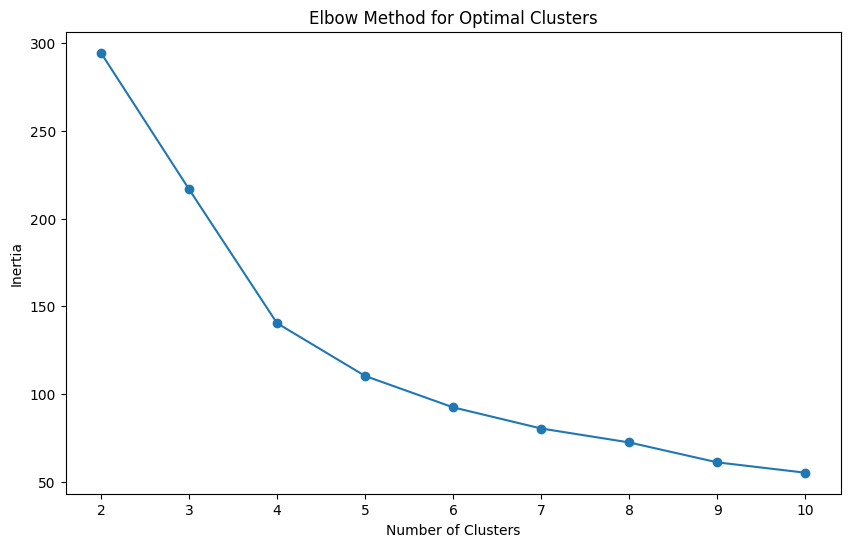

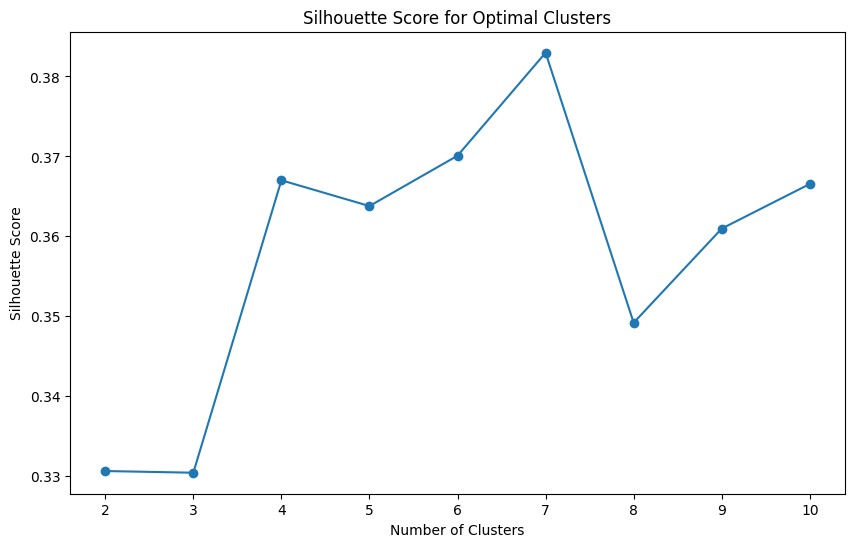

In [10]:
# **Plotting the Elbow Method**

# Plot inertia values to visualize the Elbow Point for optimal clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# **Plotting the Silhouette Scores**

# Plot silhouette scores for different cluster counts to evaluate cluster separation
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Score for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


### **Step 10: Apply KMeans Clustering**

After analyzing the results, we choose the optimal number of clusters (in this case, 3 clusters) and apply the **KMeans** algorithm.

---


In [11]:
# **Selecting the optimal number of clusters**

# Based on analysis, we choose 3 clusters (you can adjust this as needed based on plots)
n_clusters = 3

# **Applying KMeans Clustering**
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(reduced_data)

# **Calculating and Printing Silhouette Score**
silhouette_avg = silhouette_score(reduced_data, customer_profile['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.33043538580905263


c:\Users\mistr\.conda\envs\NewEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### **Step 11: Visualize the Clusters**

We visualize the clusters in the reduced 2D space (via PCA) to better understand how customers are grouped.

---


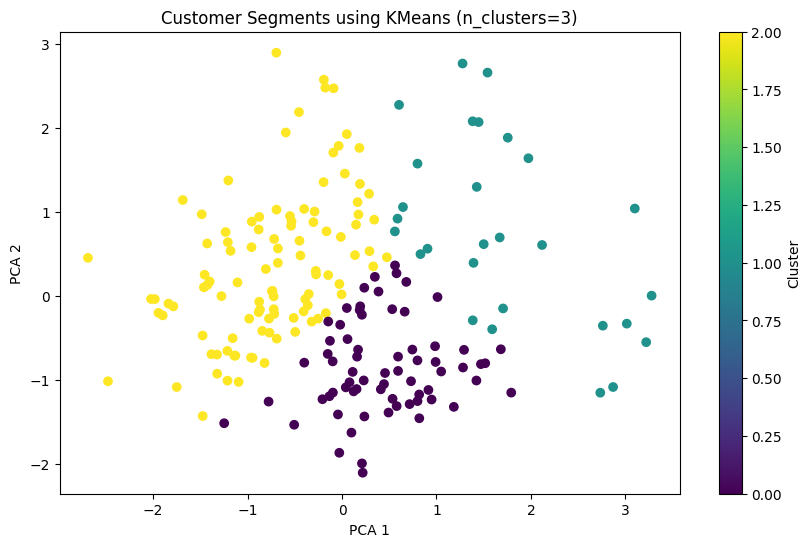

In [12]:
# **Visualizing the clusters**

# Plot the customers in the 2D PCA space, with colors representing different clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=customer_profile['Cluster'], cmap='viridis', marker='o')
plt.title(f'Customer Segments using KMeans (n_clusters={n_clusters})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


### **Step 12: Evaluate Clustering Performance**

Finally, we calculate the **Davies-Bouldin Index** to assess the quality of the clustering.

---


In [13]:
# **Evaluating the clustering with Davies-Bouldin Index**

# Calculate the Davies-Bouldin Index to evaluate the quality of the clustering
db_index = davies_bouldin_score(reduced_data, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9759019365867024
